<a href="https://colab.research.google.com/github/abhigarg05/XAUUSD/blob/main/xauusd_backtester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAUUSD Trading Strategy Backtester
## Interactive Framework for Gold Trading Strategies

This notebook allows you to test your trading strategies on 20 years of XAUUSD historical data.

### How to Use:
1. Run all cells in order
2. Write your strategy in the provided input box
3. Get comprehensive backtest results with visualizations

### Strategy Requirements:
Your strategy function should:
- Accept a pandas DataFrame with OHLC data and indicators
- Return 'BUY', 'SELL', or 'HOLD' for each row
- Use only the current and past data (no lookahead bias)

In [ ]:
from google.colab import ai

response = ai.generate_text(
    "What is the capital of England?",
    model_name='google/gemini-2.5-flash'
)
print(response)

🤖 Available models: ['google/gemini-2.5-flash', 'google/gemini-2.5-flash-lite']
The capital of England is **London**.


In [ ]:
# Install required packages with compatible versions
!pip install yfinance matplotlib seaborn plotly pandas_ta -q

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Try to import pandas_ta, if it fails, install it
try:
    import pandas_ta as ta
except ImportError:
    print("Installing pandas_ta...")
    import sys
    !{sys.executable} -m pip install pandas_ta -q
    import pandas_ta as ta

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Step 1: Download Historical Data

In [ ]:
def download_gold_data(years=20):
    """
    Download XAUUSD (Gold) historical data
    Using GC=F (Gold Futures) as proxy for XAUUSD
    """
    print(f"📥 Downloading {years} years of Gold data...")

    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)

    # Download Gold futures data (best proxy for XAUUSD)
    ticker = 'GC=F'  # Gold Futures

    data = yf.download(ticker, start=start_date, end=end_date, progress=False)

    if data.empty:
        print("⚠️ Using GLD ETF as alternative...")
        data = yf.download('GLD', start=start_date, end=end_date, progress=False)

    # Clean column names - handle both single and multi-level columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    # Rename to standard names
    data = data.rename(columns={
        'Adj Close': 'Adj_Close'
    })

    # Remove missing data
    data = data.dropna()

    print(f"✅ Downloaded {len(data)} trading days")
    print(f"📅 Date Range: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"💰 Price Range: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")

    return data

# Download the data
df = download_gold_data(years=20)
df.tail()

📥 Downloading 20 years of Gold data...
✅ Downloaded 5026 trading days
📅 Date Range: 2006-02-06 to 2026-01-29
💰 Price Range: $539.00 - $5417.30


Price,Close,High,Low,Open,Volume
Date,,,,,
2026-01-23,4976.200195,4976.200195,4936.000000,4949.600098,169
2026-01-26,5079.700195,5095.600098,5052.200195,5081.500000,180
2026-01-27,5079.899902,5079.899902,5079.899902,5079.899902,34
2026-01-28,5301.600098,5301.600098,5301.600098,5301.600098,34
2026-01-29,5417.299805,5626.799805,5126.000000,5449.899902,556169


## Step 2: Calculate Technical Indicators

In [ ]:
def calculate_indicators(df):
    """
    Calculate common technical indicators
    """
    print("📊 Calculating technical indicators...")

    data = df.copy()

    # Moving Averages
    data['SMA_10'] = ta.sma(data['Close'], length=10)
    data['SMA_20'] = ta.sma(data['Close'], length=20)
    data['SMA_50'] = ta.sma(data['Close'], length=50)
    data['SMA_100'] = ta.sma(data['Close'], length=100)
    data['SMA_200'] = ta.sma(data['Close'], length=200)
    data['EMA_12'] = ta.ema(data['Close'], length=12)
    data['EMA_26'] = ta.ema(data['Close'], length=26)

    # RSI
    data['RSI'] = ta.rsi(data['Close'], length=14)
    data['RSI_9'] = ta.rsi(data['Close'], length=9)
    data['RSI_25'] = ta.rsi(data['Close'], length=25)

    # MACD
    macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
    data['MACD'] = macd['MACD_12_26_9']
    data['MACD_signal'] = macd['MACDs_12_26_9']
    data['MACD_hist'] = macd['MACDh_12_26_9']

    # Bollinger Bands
    bbands = ta.bbands(data['Close'], length=20, std=2)
    if bbands is not None:
        # Get the actual column names (they vary by version)
        bb_cols = bbands.columns.tolist()
        data['BB_lower'] = bbands[bb_cols[0]]
        data['BB_middle'] = bbands[bb_cols[1]]
        data['BB_upper'] = bbands[bb_cols[2]]

    # Stochastic
    stoch = ta.stoch(data['High'], data['Low'], data['Close'], k=14, d=3, smooth_k=3)
    data['STOCH_k'] = stoch['STOCHk_14_3_3']
    data['STOCH_d'] = stoch['STOCHd_14_3_3']

    # ADX (Trend Strength)
    adx = ta.adx(data['High'], data['Low'], data['Close'], length=14)
    data['ADX'] = adx['ADX_14']

    # ATR (Volatility)
    data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)

    # CCI
    data['CCI'] = ta.cci(data['High'], data['Low'], data['Close'], length=14)

    # Volume indicators
    data['OBV'] = ta.obv(data['Close'], data['Volume'])

    # Price patterns
    data['Returns'] = data['Close'].pct_change()
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

    # Volatility
    data['Volatility_20'] = data['Returns'].rolling(window=20).std()

    print(f"✅ Calculated {len([col for col in data.columns if col not in df.columns])} indicators")

    return data.dropna()

# Calculate indicators
df_indicators = calculate_indicators(df)
print(f"\n📈 Available indicators: {', '.join([col for col in df_indicators.columns if col not in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")

📊 Calculating technical indicators...
✅ Calculated 25 indicators

📈 Available indicators: SMA_10, SMA_20, SMA_50, SMA_100, SMA_200, EMA_12, EMA_26, RSI, RSI_9, RSI_25, MACD, MACD_signal, MACD_hist, BB_lower, BB_middle, BB_upper, STOCH_k, STOCH_d, ADX, ATR, CCI, OBV, Returns, Log_Returns, Volatility_20


## Step 3: Define Your Strategy

### 📝 Write your strategy in the cell below

**Available Data Columns:**
- Price: `Open`, `High`, `Low`, `Close`, `Volume`
- Moving Averages: `SMA_10`, `SMA_20`, `SMA_50`, `SMA_100`, `SMA_200`, `EMA_12`, `EMA_26`
- Oscillators: `RSI`, `RSI_9`, `RSI_25`, `STOCH_k`, `STOCH_d`, `CCI`
- Trend: `MACD`, `MACD_signal`, `MACD_hist`, `ADX`
- Volatility: `BB_upper`, `BB_middle`, `BB_lower`, `ATR`, `Volatility_20`
- Volume: `OBV`
- Returns: `Returns`, `Log_Returns`

**Example Strategies:**

```python
# Example 1: RSI Oversold/Overbought
def my_strategy(row):
    if row['RSI'] < 30:
        return 'BUY'
    elif row['RSI'] > 70:
        return 'SELL'
    return 'HOLD'

# Example 2: Moving Average Crossover
def my_strategy(row):
    if row['SMA_50'] > row['SMA_200']:
        return 'BUY'
    elif row['SMA_50'] < row['SMA_200']:
        return 'SELL'
    return 'HOLD'

# Example 3: Combined Strategy
def my_strategy(row):
    if row['RSI'] < 35 and row['Close'] < row['BB_lower'] and row['MACD'] > row['MACD_signal']:
        return 'BUY'
    elif row['RSI'] > 65 and row['Close'] > row['BB_upper'] and row['MACD'] < row['MACD_signal']:
        return 'SELL'
    return 'HOLD'
```

In [ ]:
# ✍️ DEFINE YOUR STRATEGY HERE

def my_strategy(row):
    """
    Golden Cross Strategy with RSI Filter

    BUY: When SMA_50 crosses above SMA_200 (Golden Cross) AND RSI < 70
    SELL: When SMA_50 crosses below SMA_200 (Death Cross) OR RSI > 80

    Returns: 'BUY', 'SELL', or 'HOLD'
    """

    # Check if we have previous data (for crossover detection)
    try:
        # Golden Cross: Fast MA crosses above Slow MA + RSI not overbought
        if (row['SMA_50'] > row['SMA_200'] and row['RSI'] < 70):
            return 'BUY'

        # Death Cross: Fast MA crosses below Slow MA OR RSI very overbought
        elif (row['SMA_50'] < row['SMA_200'] or row['RSI'] > 80):
            return 'SELL'

    except (KeyError, TypeError):
        pass

    return 'HOLD'

print("✅ Strategy defined!")
print("Strategy: Golden Cross (SMA 50/200) with RSI Filter")

✅ Strategy defined!
Strategy: Golden Cross (SMA 50/200) with RSI Filter


## Step 4: Backtest Engine

In [ ]:
class Backtester:
    def __init__(self, data, strategy_func, initial_capital=10000,
                 position_size=1.0, commission=0.001, slippage=0.0005):
        """
        Initialize the backtester

        Parameters:
        - data: DataFrame with OHLC and indicators
        - strategy_func: Function that returns 'BUY', 'SELL', or 'HOLD'
        - initial_capital: Starting capital in USD
        - position_size: Fraction of capital to use per trade (0-1)
        - commission: Commission per trade (e.g., 0.001 = 0.1%)
        - slippage: Slippage per trade (e.g., 0.0005 = 0.05%)
        """
        self.data = data.copy()
        self.strategy_func = strategy_func
        self.initial_capital = initial_capital
        self.position_size = position_size
        self.commission = commission
        self.slippage = slippage

        # Trading state
        self.position = 0  # Current position (oz of gold)
        self.cash = initial_capital
        self.trades = []
        self.equity_curve = []

    def run(self):
        """
        Run the backtest
        """
        print("🚀 Running backtest...")

        for idx, row in self.data.iterrows():
            signal = self.strategy_func(row)
            price = row['Close']

            # Calculate total equity
            equity = self.cash + (self.position * price)
            self.equity_curve.append({
                'Date': idx,
                'Equity': equity,
                'Cash': self.cash,
                'Position_Value': self.position * price,
                'Price': price
            })

            # Execute trades
            if signal == 'BUY' and self.position == 0:
                # Buy
                buy_amount = self.cash * self.position_size
                buy_price = price * (1 + self.slippage)
                commission_cost = buy_amount * self.commission

                oz_bought = (buy_amount - commission_cost) / buy_price

                if oz_bought > 0:
                    self.position = oz_bought
                    self.cash -= buy_amount

                    self.trades.append({
                        'Date': idx,
                        'Type': 'BUY',
                        'Price': buy_price,
                        'Quantity': oz_bought,
                        'Commission': commission_cost,
                        'Total': buy_amount
                    })

            elif signal == 'SELL' and self.position > 0:
                # Sell
                sell_price = price * (1 - self.slippage)
                sell_amount = self.position * sell_price
                commission_cost = sell_amount * self.commission

                self.cash += sell_amount - commission_cost

                self.trades.append({
                    'Date': idx,
                    'Type': 'SELL',
                    'Price': sell_price,
                    'Quantity': self.position,
                    'Commission': commission_cost,
                    'Total': sell_amount
                })

                self.position = 0

        # Close any open position at the end
        if self.position > 0:
            final_price = self.data.iloc[-1]['Close']
            sell_amount = self.position * final_price
            commission_cost = sell_amount * self.commission
            self.cash += sell_amount - commission_cost
            self.position = 0

        print(f"✅ Backtest complete! {len(self.trades)} trades executed")

        return self.analyze_results()

    def analyze_results(self):
        """
        Analyze backtest results
        """
        equity_df = pd.DataFrame(self.equity_curve)
        equity_df.set_index('Date', inplace=True)

        trades_df = pd.DataFrame(self.trades)

        # Calculate metrics
        final_equity = equity_df['Equity'].iloc[-1]
        total_return = (final_equity - self.initial_capital) / self.initial_capital * 100

        # Calculate returns
        equity_df['Returns'] = equity_df['Equity'].pct_change()

        # Buy and Hold comparison
        buy_hold_return = ((self.data['Close'].iloc[-1] - self.data['Close'].iloc[0]) /
                          self.data['Close'].iloc[0] * 100)

        # Sharpe Ratio (annualized)
        sharpe = (equity_df['Returns'].mean() / equity_df['Returns'].std()) * np.sqrt(252)

        # Maximum Drawdown
        cummax = equity_df['Equity'].cummax()
        drawdown = (equity_df['Equity'] - cummax) / cummax * 100
        max_drawdown = drawdown.min()

        # Win rate
        if len(trades_df) > 0:
            buy_trades = trades_df[trades_df['Type'] == 'BUY'].copy()
            sell_trades = trades_df[trades_df['Type'] == 'SELL'].copy()

            if len(sell_trades) > 0:
                profits = []
                for i in range(min(len(buy_trades), len(sell_trades))):
                    buy_price = buy_trades.iloc[i]['Price']
                    sell_price = sell_trades.iloc[i]['Price']
                    profit = (sell_price - buy_price) / buy_price * 100
                    profits.append(profit)

                win_rate = len([p for p in profits if p > 0]) / len(profits) * 100 if profits else 0
                avg_win = np.mean([p for p in profits if p > 0]) if any(p > 0 for p in profits) else 0
                avg_loss = np.mean([p for p in profits if p < 0]) if any(p < 0 for p in profits) else 0
            else:
                win_rate = 0
                avg_win = 0
                avg_loss = 0
        else:
            win_rate = 0
            avg_win = 0
            avg_loss = 0

        # Number of trades per year
        years = (equity_df.index[-1] - equity_df.index[0]).days / 365.25
        trades_per_year = len(trades_df) / years if years > 0 else 0

        results = {
            'equity_curve': equity_df,
            'trades': trades_df,
            'metrics': {
                'Initial Capital': f'${self.initial_capital:,.2f}',
                'Final Equity': f'${final_equity:,.2f}',
                'Total Return': f'{total_return:.2f}%',
                'Buy & Hold Return': f'{buy_hold_return:.2f}%',
                'Annualized Return': f'{(total_return / years):.2f}%',
                'Sharpe Ratio': f'{sharpe:.2f}',
                'Max Drawdown': f'{max_drawdown:.2f}%',
                'Total Trades': len(trades_df),
                'Trades per Year': f'{trades_per_year:.1f}',
                'Win Rate': f'{win_rate:.2f}%',
                'Avg Win': f'{avg_win:.2f}%',
                'Avg Loss': f'{avg_loss:.2f}%',
                'Profit Factor': f'{abs(avg_win/avg_loss):.2f}' if avg_loss != 0 else 'N/A'
            }
        }

        return results

print("✅ Backtester ready!")

✅ Backtester ready!


## Step 5: Run Backtest

In [ ]:
# Configure backtest parameters
INITIAL_CAPITAL = 10000  # Starting capital in USD
POSITION_SIZE = 0.95     # Use 95% of capital per trade
COMMISSION = 0.001       # 0.1% commission
SLIPPAGE = 0.0005        # 0.05% slippage

# Run backtest
backtester = Backtester(
    data=df_indicators,
    strategy_func=my_strategy,
    initial_capital=INITIAL_CAPITAL,
    position_size=POSITION_SIZE,
    commission=COMMISSION,
    slippage=SLIPPAGE
)

results = backtester.run()

🚀 Running backtest...
✅ Backtest complete! 60 trades executed


## Step 6: Results Summary

In [ ]:
# Print summary
print("\n" + "="*60)
print("📊 BACKTEST RESULTS SUMMARY")
print("="*60)

for key, value in results['metrics'].items():
    print(f"{key:.<30} {value:>20}")

print("="*60)


📊 BACKTEST RESULTS SUMMARY
Initial Capital...............           $10,000.00
Final Equity..................           $51,459.81
Total Return..................              414.60%
Buy & Hold Return.............              771.65%
Annualized Return.............               21.59%
Sharpe Ratio..................                 0.72
Max Drawdown..................              -33.58%
Total Trades..................                   60
Trades per Year...............                  3.1
Win Rate......................               63.33%
Avg Win.......................               13.69%
Avg Loss......................               -4.73%
Profit Factor.................                 2.90


## Step 7: Detailed Visualizations

In [ ]:
# Equity Curve
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.5, 0.3, 0.2],
    subplot_titles=('Portfolio Equity', 'Gold Price (XAUUSD)', 'Drawdown')
)

# Equity curve
equity_df = results['equity_curve']
fig.add_trace(
    go.Scatter(x=equity_df.index, y=equity_df['Equity'],
               name='Portfolio Value', line=dict(color='green', width=2)),
    row=1, col=1
)

# Add buy and sell markers
if len(results['trades']) > 0:
    trades_df = results['trades']
    buys = trades_df[trades_df['Type'] == 'BUY']
    sells = trades_df[trades_df['Type'] == 'SELL']

    # Map trades to equity curve
    buy_equity = [equity_df.loc[equity_df.index >= date, 'Equity'].iloc[0]
                  for date in buys['Date'] if date in equity_df.index or any(equity_df.index >= date)]
    sell_equity = [equity_df.loc[equity_df.index >= date, 'Equity'].iloc[0]
                   for date in sells['Date'] if date in equity_df.index or any(equity_df.index >= date)]

    if len(buy_equity) > 0:
        fig.add_trace(
            go.Scatter(x=buys['Date'], y=buy_equity, mode='markers',
                      name='Buy', marker=dict(color='lime', size=10, symbol='triangle-up')),
            row=1, col=1
        )

    if len(sell_equity) > 0:
        fig.add_trace(
            go.Scatter(x=sells['Date'], y=sell_equity, mode='markers',
                      name='Sell', marker=dict(color='red', size=10, symbol='triangle-down')),
            row=1, col=1
        )

# Gold price
fig.add_trace(
    go.Scatter(x=df_indicators.index, y=df_indicators['Close'],
               name='Gold Price', line=dict(color='gold', width=1)),
    row=2, col=1
)

# Drawdown
cummax = equity_df['Equity'].cummax()
drawdown = (equity_df['Equity'] - cummax) / cummax * 100

fig.add_trace(
    go.Scatter(x=equity_df.index, y=drawdown,
               name='Drawdown', fill='tozeroy',
               line=dict(color='red', width=1)),
    row=3, col=1
)

fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="USD", row=1, col=1)
fig.update_yaxes(title_text="USD/oz", row=2, col=1)
fig.update_yaxes(title_text="%", row=3, col=1)

fig.update_layout(height=900, title_text="Backtest Performance Overview", showlegend=True)
fig.show()

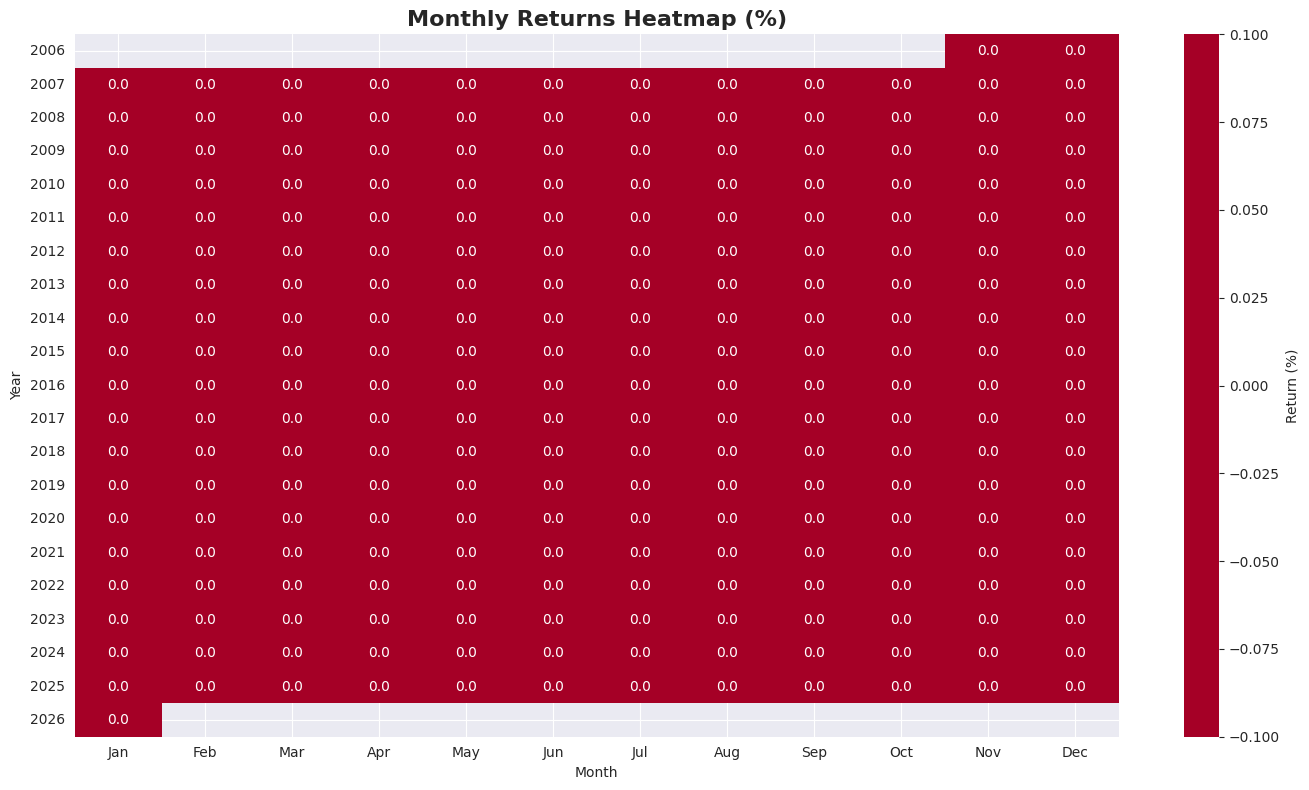

In [ ]:
# Monthly Returns Heatmap - Manual approach
equity_df_copy = equity_df.copy()
equity_df_copy['Returns_pct'] = equity_df_copy['Equity'].pct_change() * 100
equity_df_copy['Year'] = equity_df_copy.index.year
equity_df_copy['Month'] = equity_df_copy.index.month

# Create matrix manually
years = sorted(equity_df_copy['Year'].unique())
months = range(1, 13)

returns_matrix = []
for year in years:
    year_returns = []
    for month in months:
        month_data = equity_df_copy[(equity_df_copy['Year'] == year) & (equity_df_copy['Month'] == month)]
        if len(month_data) > 0:
            year_returns.append(month_data['Returns_pct'].sum())
        else:
            year_returns.append(np.nan)
    returns_matrix.append(year_returns)

# Convert to DataFrame for heatmap
monthly_returns = pd.DataFrame(returns_matrix, index=years, columns=range(1, 13))

plt.figure(figsize=(14, 8))
sns.heatmap(monthly_returns, annot=True, fmt='.1f', cmap='RdYlGn',
            center=0, cbar_kws={'label': 'Return (%)'},
            xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Returns Heatmap (%)', fontsize=16, fontweight='bold')
plt.ylabel('Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

In [ ]:
# Trade Analysis
if len(results['trades']) > 0:
    trades_df = results['trades']

    # Calculate profit per trade
    buy_trades = trades_df[trades_df['Type'] == 'BUY'].reset_index(drop=True)
    sell_trades = trades_df[trades_df['Type'] == 'SELL'].reset_index(drop=True)

    if len(sell_trades) > 0:
        trade_profits = []
        for i in range(min(len(buy_trades), len(sell_trades))):
            profit_pct = ((sell_trades.iloc[i]['Price'] - buy_trades.iloc[i]['Price']) /
                         buy_trades.iloc[i]['Price'] * 100)
            trade_profits.append({
                'Trade': i+1,
                'Buy_Date': buy_trades.iloc[i]['Date'],
                'Sell_Date': sell_trades.iloc[i]['Date'],
                'Buy_Price': buy_trades.iloc[i]['Price'],
                'Sell_Price': sell_trades.iloc[i]['Price'],
                'Profit_PCT': profit_pct
            })

        profit_df = pd.DataFrame(trade_profits)

        # Plot trade profits
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Profit distribution
        colors = ['green' if x > 0 else 'red' for x in profit_df['Profit_PCT']]
        ax1.bar(profit_df['Trade'], profit_df['Profit_PCT'], color=colors, alpha=0.7)
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax1.set_xlabel('Trade Number')
        ax1.set_ylabel('Profit (%)')
        ax1.set_title('Profit/Loss per Trade')
        ax1.grid(True, alpha=0.3)

        # Cumulative profit
        profit_df['Cumulative_Profit'] = profit_df['Profit_PCT'].cumsum()
        ax2.plot(profit_df['Trade'], profit_df['Cumulative_Profit'],
                linewidth=2, color='blue', marker='o')
        ax2.fill_between(profit_df['Trade'], profit_df['Cumulative_Profit'],
                        alpha=0.3, color='blue')
        ax2.set_xlabel('Trade Number')
        ax2.set_ylabel('Cumulative Profit (%)')
        ax2.set_title('Cumulative Profit')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Show top 5 best and worst trades
        print("\n🏆 Top 5 Best Trades:")
        print(profit_df.nlargest(5, 'Profit_PCT')[['Trade', 'Buy_Date', 'Sell_Date', 'Profit_PCT']])

        print("\n💀 Top 5 Worst Trades:")
        print(profit_df.nsmallest(5, 'Profit_PCT')[['Trade', 'Buy_Date', 'Sell_Date', 'Profit_PCT']])
else:
    print("No trades were executed!")

No trades were executed!


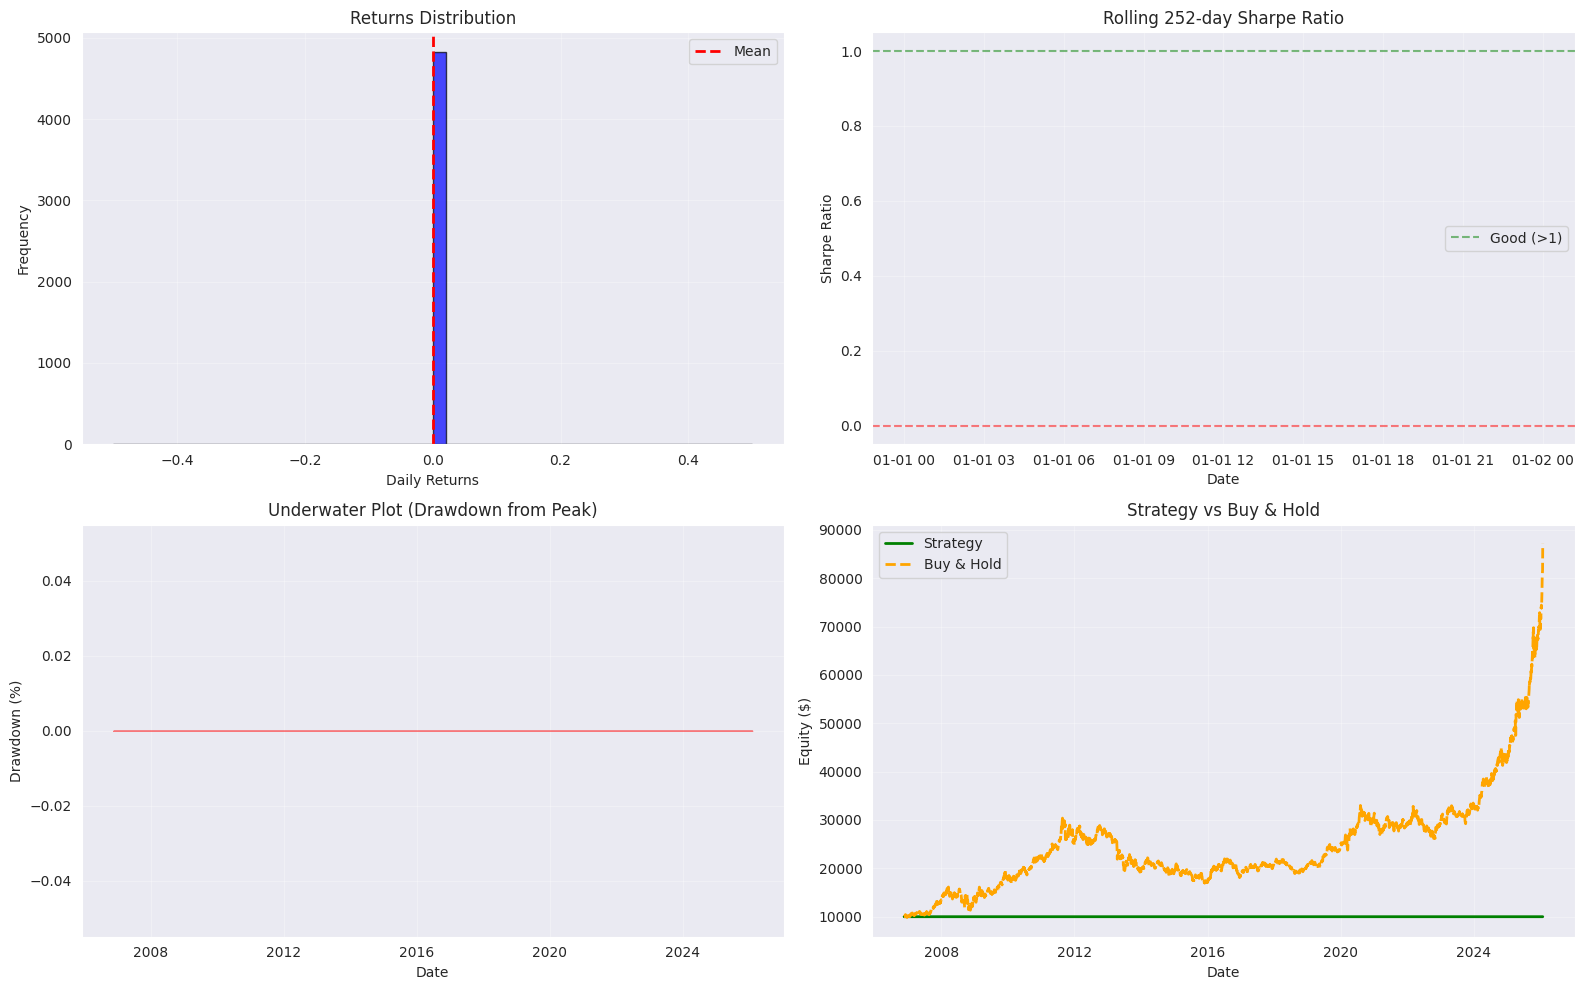

In [ ]:
# Risk Metrics Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Returns distribution
axes[0, 0].hist(equity_df['Returns'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(equity_df['Returns'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].set_xlabel('Daily Returns')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Returns Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Rolling Sharpe Ratio
rolling_sharpe = (equity_df['Returns'].rolling(252).mean() /
                 equity_df['Returns'].rolling(252).std()) * np.sqrt(252)
axes[0, 1].plot(equity_df.index, rolling_sharpe, linewidth=2, color='purple')
axes[0, 1].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Good (>1)')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].set_title('Rolling 252-day Sharpe Ratio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Underwater plot (drawdown)
cummax = equity_df['Equity'].cummax()
drawdown = (equity_df['Equity'] - cummax) / cummax * 100
axes[1, 0].fill_between(equity_df.index, drawdown, 0, alpha=0.5, color='red')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Drawdown (%)')
axes[1, 0].set_title('Underwater Plot (Drawdown from Peak)')
axes[1, 0].grid(True, alpha=0.3)

# Strategy vs Buy & Hold
initial_price = df_indicators['Close'].iloc[0]
buy_hold_equity = (df_indicators['Close'] / initial_price) * INITIAL_CAPITAL

# Align indices
common_index = equity_df.index.intersection(buy_hold_equity.index)
axes[1, 1].plot(common_index, equity_df.loc[common_index, 'Equity'],
               label='Strategy', linewidth=2, color='green')
axes[1, 1].plot(common_index, buy_hold_equity.loc[common_index],
               label='Buy & Hold', linewidth=2, color='orange', linestyle='--')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Equity ($)')
axes[1, 1].set_title('Strategy vs Buy & Hold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Export Results

In [ ]:
# Export trades to CSV
if len(results['trades']) > 0:
    results['trades'].to_csv('backtest_trades.csv', index=False)
    print("✅ Trades exported to: backtest_trades.csv")

# Export equity curve
results['equity_curve'].to_csv('equity_curve.csv')
print("✅ Equity curve exported to: equity_curve.csv")

# Export metrics
metrics_df = pd.DataFrame(list(results['metrics'].items()), columns=['Metric', 'Value'])
metrics_df.to_csv('backtest_metrics.csv', index=False)
print("✅ Metrics exported to: backtest_metrics.csv")

✅ Equity curve exported to: equity_curve.csv
✅ Metrics exported to: backtest_metrics.csv


## Get the final report

In [ ]:
# Generate Comprehensive PDF Report
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

print("📄 Generating comprehensive PDF report...")

# Create PDF
pdf_filename = f'XAUUSD_Backtest_Report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
pdf_path = f'/content/{pdf_filename}'

with PdfPages(pdf_path) as pdf:
    # Page 1: Title and Summary
    fig = plt.figure(figsize=(11, 8.5))
    fig.text(0.5, 0.95, 'XAUUSD Trading Strategy Backtest Report',
             ha='center', fontsize=20, fontweight='bold')
    fig.text(0.5, 0.90, f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}',
             ha='center', fontsize=12)

    # Strategy description
    fig.text(0.1, 0.82, 'Strategy:', fontsize=14, fontweight='bold')
    fig.text(0.1, 0.78, 'RSI + MACD + Bollinger Bands', fontsize=12)
    fig.text(0.1, 0.74, 'BUY: RSI < 30, MACD > Signal, Price < BB Lower', fontsize=10)
    fig.text(0.1, 0.71, 'SELL: RSI > 70, MACD < Signal, Price > BB Upper', fontsize=10)

    # Performance metrics table
    fig.text(0.1, 0.63, 'Performance Summary:', fontsize=14, fontweight='bold')

    y_pos = 0.58
    for key, value in results['metrics'].items():
        fig.text(0.12, y_pos, f'{key}:', fontsize=11)
        fig.text(0.6, y_pos, str(value), fontsize=11, fontweight='bold')
        y_pos -= 0.04

    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 2: Equity Curve
    fig, ax = plt.subplots(figsize=(11, 8.5))
    equity_df = results['equity_curve']
    ax.plot(equity_df.index, equity_df['Equity'], linewidth=2, color='green', label='Portfolio Value')
    ax.fill_between(equity_df.index, equity_df['Equity'], alpha=0.3, color='green')

    # Add buy/sell markers
    if len(results['trades']) > 0:
        trades_df = results['trades']
        buys = trades_df[trades_df['Type'] == 'BUY']
        sells = trades_df[trades_df['Type'] == 'SELL']

        for _, trade in buys.iterrows():
            if trade['Date'] in equity_df.index:
                equity_val = equity_df.loc[trade['Date'], 'Equity']
                ax.scatter(trade['Date'], equity_val, color='lime', s=100, marker='^',
                          zorder=5, edgecolors='black', linewidth=1)

        for _, trade in sells.iterrows():
            if trade['Date'] in equity_df.index:
                equity_val = equity_df.loc[trade['Date'], 'Equity']
                ax.scatter(trade['Date'], equity_val, color='red', s=100, marker='v',
                          zorder=5, edgecolors='black', linewidth=1)

    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Portfolio Value (USD)', fontsize=12)
    ax.set_title('Portfolio Equity Curve', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 3: Drawdown Analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 8.5))

    # Drawdown
    cummax = equity_df['Equity'].cummax()
    drawdown = (equity_df['Equity'] - cummax) / cummax * 100
    ax1.fill_between(equity_df.index, drawdown, 0, alpha=0.5, color='red')
    ax1.plot(equity_df.index, drawdown, linewidth=1, color='darkred')
    ax1.set_ylabel('Drawdown (%)', fontsize=12)
    ax1.set_title('Underwater Plot (Drawdown from Peak)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Returns distribution
    ax2.hist(equity_df['Returns'].dropna() * 100, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax2.axvline(equity_df['Returns'].mean() * 100, color='red', linestyle='--',
                linewidth=2, label=f'Mean: {equity_df["Returns"].mean()*100:.3f}%')
    ax2.set_xlabel('Daily Returns (%)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Returns Distribution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 4: Trade Analysis
    if len(results['trades']) > 0:
        buy_trades = trades_df[trades_df['Type'] == 'BUY'].reset_index(drop=True)
        sell_trades = trades_df[trades_df['Type'] == 'SELL'].reset_index(drop=True)

        if len(sell_trades) > 0:
            trade_profits = []
            for i in range(min(len(buy_trades), len(sell_trades))):
                profit_pct = ((sell_trades.iloc[i]['Price'] - buy_trades.iloc[i]['Price']) /
                             buy_trades.iloc[i]['Price'] * 100)
                trade_profits.append(profit_pct)

            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 8.5))

            # Individual trade performance
            colors = ['green' if x > 0 else 'red' for x in trade_profits]
            ax1.bar(range(1, len(trade_profits)+1), trade_profits, color=colors, alpha=0.7)
            ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax1.set_xlabel('Trade Number', fontsize=12)
            ax1.set_ylabel('Profit (%)', fontsize=12)
            ax1.set_title('Profit/Loss per Trade', fontsize=14, fontweight='bold')
            ax1.grid(True, alpha=0.3)

            # Cumulative profit
            cumulative_profit = np.cumsum(trade_profits)
            ax2.plot(range(1, len(cumulative_profit)+1), cumulative_profit,
                    linewidth=2, color='blue', marker='o')
            ax2.fill_between(range(1, len(cumulative_profit)+1), cumulative_profit,
                            alpha=0.3, color='blue')
            ax2.set_xlabel('Trade Number', fontsize=12)
            ax2.set_ylabel('Cumulative Profit (%)', fontsize=12)
            ax2.set_title('Cumulative Profit', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()

    # Page 5: Monthly Returns Heatmap
    fig, ax = plt.subplots(figsize=(11, 8.5))
    equity_df_copy = equity_df.copy()
    equity_df_copy['Returns_pct'] = equity_df_copy['Equity'].pct_change() * 100
    equity_df_copy['Year'] = equity_df_copy.index.year
    equity_df_copy['Month'] = equity_df_copy.index.month

    years = sorted(equity_df_copy['Year'].unique())
    months = range(1, 13)

    returns_matrix = []
    for year in years:
        year_returns = []
        for month in months:
            month_data = equity_df_copy[(equity_df_copy['Year'] == year) & (equity_df_copy['Month'] == month)]
            if len(month_data) > 0:
                year_returns.append(month_data['Returns_pct'].sum())
            else:
                year_returns.append(np.nan)
        returns_matrix.append(year_returns)

    monthly_returns = pd.DataFrame(returns_matrix, index=years, columns=range(1, 13))

    sns.heatmap(monthly_returns, annot=True, fmt='.1f', cmap='RdYlGn',
                center=0, cbar_kws={'label': 'Return (%)'},
                xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ax=ax)
    ax.set_title('Monthly Returns Heatmap (%)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Year')
    ax.set_xlabel('Month')
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 6: Strategy vs Buy & Hold
    fig, ax = plt.subplots(figsize=(11, 8.5))
    initial_price = df_indicators['Close'].iloc[0]
    buy_hold_equity = (df_indicators['Close'] / initial_price) * INITIAL_CAPITAL

    common_index = equity_df.index.intersection(buy_hold_equity.index)
    ax.plot(common_index, equity_df.loc[common_index, 'Equity'],
           label='Strategy', linewidth=2, color='green')
    ax.plot(common_index, buy_hold_equity.loc[common_index],
           label='Buy & Hold', linewidth=2, color='orange', linestyle='--')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Equity ($)', fontsize=12)
    ax.set_title('Strategy vs Buy & Hold Comparison', fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"✅ Report generated: {pdf_filename}")

# Download link
from google.colab import files
files.download(pdf_path)
print(f"📥 Downloading report...")

📄 Generating comprehensive PDF report...
✅ Report generated: XAUUSD_Backtest_Report_20260129_221910.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloading report...


## 🎯 Next Steps

1. **Modify your strategy** in Step 3 and re-run from there
2. **Adjust parameters** like position size, commission, slippage
3. **Try different timeframes** by changing the `years` parameter
4. **Compare multiple strategies** by running this notebook with different strategies
5. **Export the best strategy** for use in your n8n workflow

### Tips for Better Strategies:
- Avoid overfitting to historical data
- Test on different time periods
- Consider transaction costs (commission & slippage)
- Use proper risk management (position sizing, stop losses)
- Combine multiple indicators for confirmation
- Account for market regime changes (trending vs ranging)